In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import numpy as np
from tqdm import tqdm
import itertools
import os
import pandas as pd
from google.colab import drive
import pickle
import random

In [2]:
class BanditEnvironment:
    def __init__(self, difficulty, max_steps = 100):
        self.num_actions = 2  # Number of actions (arms/bandits)
        self.difficulty = difficulty
        self.max_steps = max_steps  # Maximum number of steps per episode
        self.reset()

    def reset(self):
        """Reset the environment to its initial state."""

        # Set brenoulli probabilities for difficulties
        if self.difficulty == 'easy':
            bandits_prob = np.random.choice([0.9, 0.1])
            self.bandits_prob = np.array([bandits_prob, 1 - bandits_prob])
        elif self.difficulty == 'medium':
            bandits_prob = np.random.choice([0.75, 0.25])
            self.bandits_prob = np.array([bandits_prob, 1 - bandits_prob])
        elif self.difficulty == 'hard':
            bandits_prob = np.random.choice([0.6, 0.4])
            self.bandits_prob = np.array([bandits_prob, 1 - bandits_prob])
        elif self.difficulty == 'uniform':
            bandits_prob = np.random.uniform()
            self.bandits_prob = np.array([bandits_prob, 1 - bandits_prob])
        else:  # Independent difficulty (random probabilities for each arm)
            self.bandits_prob = np.random.uniform(size=2)

        self.timestep = 0  # Initialize timestep
        self.last_action = None
        self.last_reward = 0
        return

    def step(self, action):
        """Take an action and return the next state, reward, and done flag."""
        self.timestep += 1
        self.last_action = action
        bandit_prob = self.bandits_prob[action]
        reward = 1 if np.random.uniform() < bandit_prob else 0
        self.last_reward = reward
        done = self.timestep >= self.max_steps  # End episode after 100 timesteps
        return reward, done



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def ucb(Q, N, t, c):
    vals = Q + c * np.sqrt((np.log(t)) / (N + 1e-8))
    return np.argmax(vals)
    # t = numero de iteracion
    # N cantidad de veces que se selecciona la accion hasta t
    # we return the index of the max "vals" (not Q)

In [10]:
def cumulative_regret_function(action, bandits_prob):
    cumulative_regret = np.max(bandits_prob) - bandits_prob[action]
    return cumulative_regret

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
def average(tot_cumulative_regret):
    avg = []
    for i in range(len(tot_cumulative_regret[0])):
        temp = 0
        for j in range(len(tot_cumulative_regret)):
            temp += tot_cumulative_regret[j][i]
        temp /= len(tot_cumulative_regret)
        avg.append(temp)
    return avg

In [21]:
np.random.seed(42)
k = 2  # Number of actions (arms)
iter = 100 # Number of steps
repeat = 20000 # Number of repetitions
difficulties = ['easy', 'medium', 'hard', 'uniform', 'independent']
c = 1.0
results = pd.DataFrame()

for difficulty in difficulties:

    print(difficulty)
    env = BanditEnvironment(difficulty)
    env.reset()
    tot_rewards = []
    tot_cumulative_regret = []

    for _ in tqdm(range(repeat)):
        Q = np.zeros(shape=(k))
        N = np.zeros(shape=(k))
        rewards = []
        cumulative_regret = 0
        cumulative_regrets = []
        for i in range(iter):
            action = ucb(Q, N, i+1, c) # we only change how the action is selected (not more get_action, now ucb)
            reward, done = env.step(action)
            rewards.append(reward)
            cumulative_regret = cumulative_regret + cumulative_regret_function(action, env.bandits_prob)
            cumulative_regrets.append(cumulative_regret)
            N[action] += 1
            Q[action] = Q[action] +  1/N[action] * (reward - Q[action])
        env.reset()
        tot_rewards.append(rewards)
        tot_cumulative_regret.append(cumulative_regrets)

    # Average Results
    results[difficulty] = average(tot_cumulative_regret)

easy


100%|██████████| 20000/20000 [01:09<00:00, 287.46it/s]


medium


100%|██████████| 20000/20000 [01:03<00:00, 313.09it/s]


hard


100%|██████████| 20000/20000 [01:04<00:00, 310.28it/s]


uniform


100%|██████████| 20000/20000 [01:03<00:00, 314.48it/s]


independent


100%|██████████| 20000/20000 [01:09<00:00, 286.93it/s]


In [23]:
results.to_csv('UCB_exp_1and2.csv', index = False)

<Axes: >

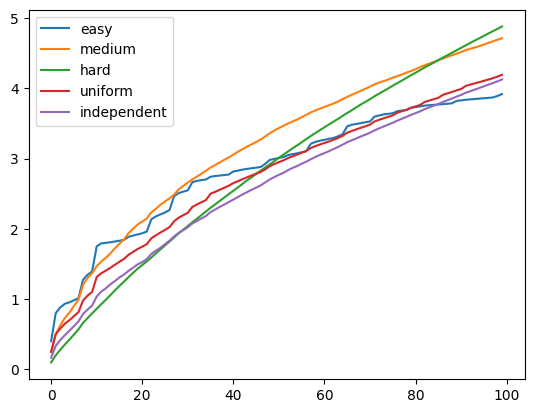

In [27]:
# plot using pandas
results.plot()